In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import ndarray as NDArray
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from typing import Iterable, Text, Union
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [5]:
# Download NLTK resources (run only once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')
training_data = pd.read_csv("/content/drive/MyDrive/train.csv")
testing_data = pd.read_csv("/content/drive/MyDrive/test.csv")


Mounted at /content/drive


In [7]:
# Measure of diversity
total_reviews = len(training_data)
unique_reviews = len(training_data['TEXT'].unique())
diversity = unique_reviews / total_reviews
print("Measure of Diversity:", diversity)

# Dataset size per class
class_counts = training_data['LABEL'].value_counts()
print("Dataset Size per Class:")
print(class_counts)

# Example data points
example_data_points = {}
for label in class_counts.index:
    example_data_points[label] = training_data[training_data['LABEL'] == label]['TEXT'].iloc[0]

# Print example data points
print("\nExample Data Points:")
for label, data_point in example_data_points.items():
    print("Class:", label)
    print("Example Data Point:", data_point)
    print()

Measure of Diversity: 0.9862479912396718
Dataset Size per Class:
LABEL
0    32071
1    19276
2    18970
Name: count, dtype: int64

Example Data Points:
Class: 0
Example Data Point: I paid something like 89 cents for this book through Amazon.  I use it all the time.  It shows many, many cross stitches and has pretty patterns.

Class: 1
Example Data Point: I saw Anatomy years ago -- dubbed at a friends house I don't remember it much, and then I saw at the video store there is a second one -- not really related to the first one Franka Ponte makes a little cameo. And that one was okay not as good as the first one. I'm seeing the first one again tonight -- not dubbed collectors edition. I really like German movies like this one it's very interesting and people and cults like the one in the movie could exist i think, i dunno. But it's very grossly entertaining and scary. Anatomy 2 is a little different and the characters are not as good as the first. But if you really thought Anatomy was int

<ipython-input-8-cf4cbaefd267>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette='Set1')


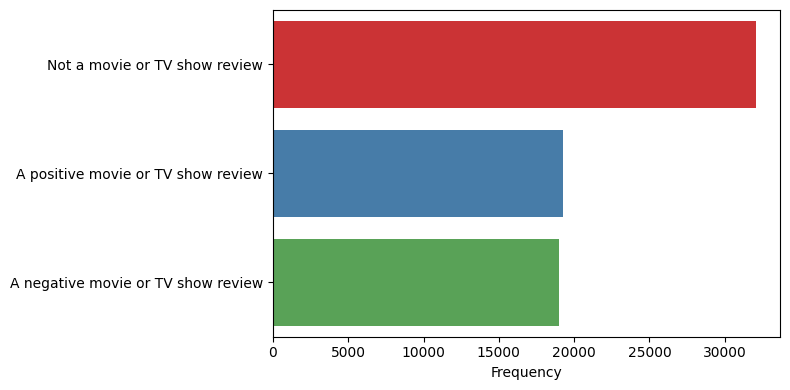

In [8]:
label_counts = training_data['LABEL'].value_counts()

plot_labels = {
    0 : 'Not a movie or TV show review',
    1 : 'A positive movie or TV show review',
    2 : 'A negative movie or TV show review'
}

label_counts.rename(index=plot_labels, inplace=True)

plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='Set1')
plt.xlabel('Frequency')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [68]:
def transform_column(dataset):
  """Function to transform the null values and datatypes

  Args:
      dataset (pd.Dataframe)

  Returns:
      pd.Dataframe
  """
  dataset['TEXT'] = dataset['TEXT'].fillna('EMPTY REVIEW')
  dataset['TEXT'] = dataset['TEXT'].astype(str)
  return dataset

# Applying the function on both train and test data
new_training_data = transform_column(training_data)
new_testing_data = transform_column(testing_data)

In [69]:
# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


lemmatizer = WordNetLemmatizer()

# stop_words = set(stopwords.words('english')) - didn't help improve the model for some reason

def process_text(text):
    """Process the input text by tokenizing, lemmatizing

    Args:
        text (str): Input text to be processed

    Returns:
        str: Processed text
    """
    tokens = word_tokenize(text.lower())
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = " ".join(processed_tokens)
    return processed_text

new_training_data['TEXT'] = new_training_data['TEXT'].apply(process_text)

In [74]:
# Separating train and test data for features and labels
X_train = new_training_data['TEXT']
y_train = new_training_data['LABEL']
X_test = new_testing_data['TEXT']

# Using TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression with Grid Search for Hyperparameter Tuning
logistic_classifier = LogisticRegression(class_weight="balanced", max_iter=2000)

# Define the pipeline with TF-IDF vectorizer and Logistic Regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', logistic_classifier)
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'classifier__C': [0.1, 1, 10],
    # Add more hyperparameters as needed
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Re-train the model with the best parameters
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

# Training data accuracy
y_train_pred = best_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("Logistic Regression Training Accuracy:", train_acc)
print("======================================================")
print(classification_report(y_train, y_train_pred))

# Predicting on test data
y_pred_final = best_pipeline.predict(X_test)

# Save predictions to a CSV file
submission_df = pd.DataFrame({'ID': testing_data['ID'], 'LABEL': y_pred_final})
submission_df.to_csv('submission.csv', index=False)

# Error Analysis and Model Evaluation
# Cross-validation predictions
cv_predictions = cross_val_predict(best_pipeline, X_train, y_train, cv=5)
# Confusion matrix
conf_matrix = confusion_matrix(y_train, cv_predictions)
print("Confusion Matrix:")
print(conf_matrix)
# Classification report
print("Classification Report:")
print(classification_report(y_train, cv_predictions))

Best Parameters: {'classifier__C': 1, 'tfidf__max_features': 10000}
Logistic Regression Training Accuracy: 0.9504102848528805
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     32071
           1       0.92      0.92      0.92     19276
           2       0.93      0.92      0.93     18970

    accuracy                           0.95     70317
   macro avg       0.94      0.94      0.94     70317
weighted avg       0.95      0.95      0.95     70317

Confusion Matrix:
[[31473   369   229]
 [  627 16879  1770]
 [  352  1998 16620]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     32071
           1       0.88      0.88      0.88     19276
           2       0.89      0.88      0.88     18970

    accuracy                           0.92     70317
   macro avg       0.91      0.91      0.91     70317
weighted avg       0.92      0.92      0.92     70317



In [75]:
submission_df = pd.DataFrame({'ID': testing_data['ID'], 'LABEL': y_pred_final})
submission_df.to_csv('/content/drive/MyDrive/submission1.csv', index=False)